# NFL 49ers - Check Retention Scores
* StellarAlgo Data Science
* Grant Donst
* Aug 23, 2022

In [1]:
import getpass
import pandas as pd
import pyodbc

import matplotlib.pyplot as plt

#from pandas_profiling import ProfileReport
from pycaret.classification import *

### Let's grab the training and eval datasets:

In [2]:
#df_train = pd.read_csv("./data/train.csv")
#df_eval = pd.read_csv("./data/eval.csv")

#df_train = pd.concat([df_train, df_eval])

In [3]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [17]:
lkupclientid = 95 # 49ers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNFL49ers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(72380, 53)

In [18]:
features = [
    "recentDate",
    "dimCustomerMasterId",
    "productGrouping",
    "year",
    "attendancePercent", 
    "distToVenue",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent",
    "isNextYear_Buyer"
]

# choose features for each train dataset
df = df[features]

df["year"] = pd.to_numeric(df["year"])

In [19]:
df_train = df[df["year"] <= 2019]
df_train_2018 = df_train[df_train["year"] <= 2018]
df_train_2019 = df_train[df_train["year"] >= 2019]

print(df_train["year"].value_counts())
print(df_train_2018["year"].value_counts())
print(df_train_2019["year"].value_counts())

2018    18181
2019    17817
Name: year, dtype: int64
2018    18181
Name: year, dtype: int64
2019    17817
Name: year, dtype: int64


In [20]:
print(df_train["isNextYear_Buyer"].value_counts())
print(df_train_2018["isNextYear_Buyer"].value_counts())
print(df_train_2019["isNextYear_Buyer"].value_counts())

1    33941
0     2057
Name: isNextYear_Buyer, dtype: int64
1    17150
0     1031
Name: isNextYear_Buyer, dtype: int64
1    16791
0     1026
Name: isNextYear_Buyer, dtype: int64


### Let's set up our new model:

In [21]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentDate"
    ],
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "year"
    ],
    numeric_features=[
        "attendancePercent", 
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ],
    silent=True,
    verbose=False
);

best_model = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9444,0.7075,0.9986,0.9454,0.9713,0.0935,0.1851,0.7880


### Let's finalize our new model so it can be used to make predictions:

In [22]:
final_model = create_model(best_model)
new_retention_model = finalize_model(final_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9435,0.7244,0.9993,0.9440,0.9709,0.0505,0.1351
1,0.9454,0.7257,0.9986,0.9464,0.9718,0.1259,0.2270
2,0.9451,0.7151,0.9990,0.9458,0.9717,0.1082,0.2120
3,0.9444,0.6900,0.9993,0.9449,0.9714,0.0803,0.1826
4,0.9435,0.6689,0.9983,0.9449,0.9708,0.0774,0.1565
5,0.9438,0.7326,0.9969,0.9463,0.9710,0.1201,0.1950
6,0.9458,0.7498,0.9990,0.9465,0.9720,0.1270,0.2351
7,0.9441,0.7197,0.9986,0.9452,0.9712,0.0880,0.1781
8,0.9441,0.6680,0.9986,0.9452,0.9712,0.0788,0.1647
9,0.9441,0.6812,0.9986,0.9452,0.9712,0.0788,0.1647


### Let's also load the model used in retention for production:

In [23]:
prod_retention_model = load_model("./models/model")

Transformation Pipeline and Model Successfully Loaded


### Let's use the new and existing model to make predictions on the 2022 season:

In [24]:
inference_data = pd.read_csv("./data/inference_data.csv")
inference_data.columns = ['attendancePercent', 'clientcode', 'dimCustomerMasterId', 'distToVenue', 'isNextYear_Buyer', 'lkupclientid',
                          'missed_games_1', 'missed_games_2', 'missed_games_over_2', 'productGrouping', 'recency', 'recentDate',
                          'renewedBeforeDays', 'source_tenure', 'totalSpent', 'year']

inference_data = inference_data.loc[inference_data['lkupclientid']==95]

In [25]:
inference_data["year"].value_counts()

2021    18274
Name: year, dtype: int64

### Let's use our model to make predictions on the inference data:

In [26]:
df_new_predictions = predict_model(new_retention_model, data=inference_data, raw_score=True)
df_prod_predictions = predict_model(prod_retention_model, data=inference_data, raw_score=True)

In [27]:
df_new_predictions.head()

,attendancePercent,clientcode,dimCustomerMasterId,distToVenue,isNextYear_Buyer,lkupclientid,missed_games_1,missed_games_2,missed_games_over_2,productGrouping,recency,recentDate,renewedBeforeDays,source_tenure,totalSpent,year,Label,Score_0,Score_1
0,0.000000,NFL49ERS,1304,0,1,95,0,0,1,Full Season,0,1970-01-01,104,2920,13600.0,2021,1,0.1462,0.8538
1,0.722222,NFL49ERS,1361,0,1,95,1,1,0,Full Season,0,2022-01-02,104,3650,4500.0,2021,1,0.0393,0.9607
2,0.000000,NFL49ERS,1392,0,1,95,0,0,1,Full Season,0,1970-01-01,104,2555,26600.0,2021,1,0.1794,0.8206
3,0.555556,NFL49ERS,1403,0,1,95,1,2,0,Full Season,0,2022-01-02,104,6205,7800.0,2021,1,0.0182,0.9818
4,0.000000,NFL49ERS,1412,0,0,95,0,0,1,Full Season,0,1970-01-01,147,2920,2416.0,2021,1,0.1732,0.8268


### Let's visualize the data and see the prediction scores for fans that will renew:

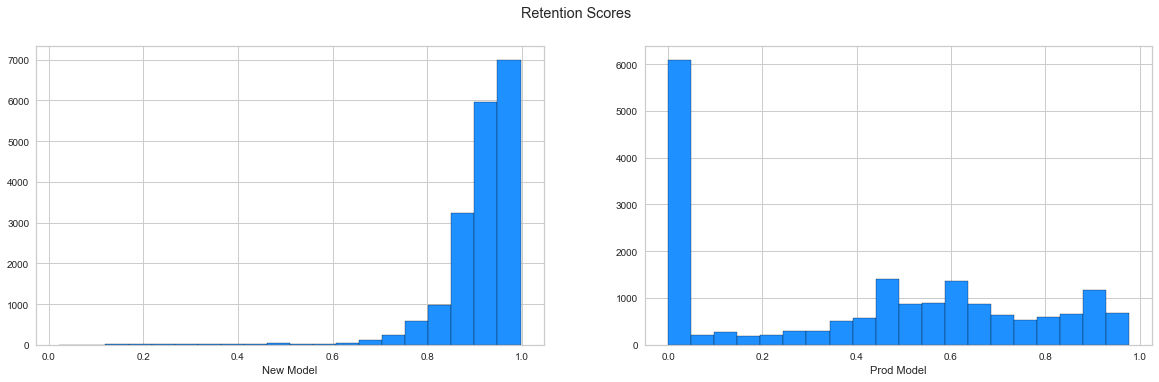

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Scores')
ax1.hist(df_new_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax2.hist(df_prod_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('New Model')
ax2.set_xlabel('Prod Model')

fig.figure.set_figwidth(20)

### We can also generate a report to do some exploratory data analysis on our training dataset:

In [ ]:
#profile = ProfileReport(df_train, minimal=True)
#profile.to_file("pandas-profile-report-2018.html")